In [7]:
!git clone https://github.com/Lhyejin/LaneNet-PyTorch.git

Cloning into 'LaneNet-PyTorch'...
remote: Enumerating objects: 191, done.
remote: Counting objects: 100% (191/191), done.
remote: Compressing objects: 100% (156/156), done.
remote: Total 191 (delta 55), reused 154 (delta 27), pack-reused 0
Receiving objects: 100% (191/191), 29.32 MiB | 36.52 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [8]:
%cd LaneNet-PyTorch//
!ls
!pip install -r requirements.txt

/content/LaneNet-PyTorch
dataset  LICENSE	      requirements.txt	Train.ipynb
img	 Notebook-experiment  test.py		TUSIMPLE
Lanenet  README.md	      Train_aug.ipynb	utils
     |████████████████████████████████| 748.9MB 14kB/s 
     |████████████████████████████████| 8.8MB 130kB/s 
     |████████████████████████████████| 7.0MB 48.1MB/s 
     |████████████████████████████████| 20.2MB 1.3MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.2.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.18.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Found existing installation: torch 1.8.1+cu101
  

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


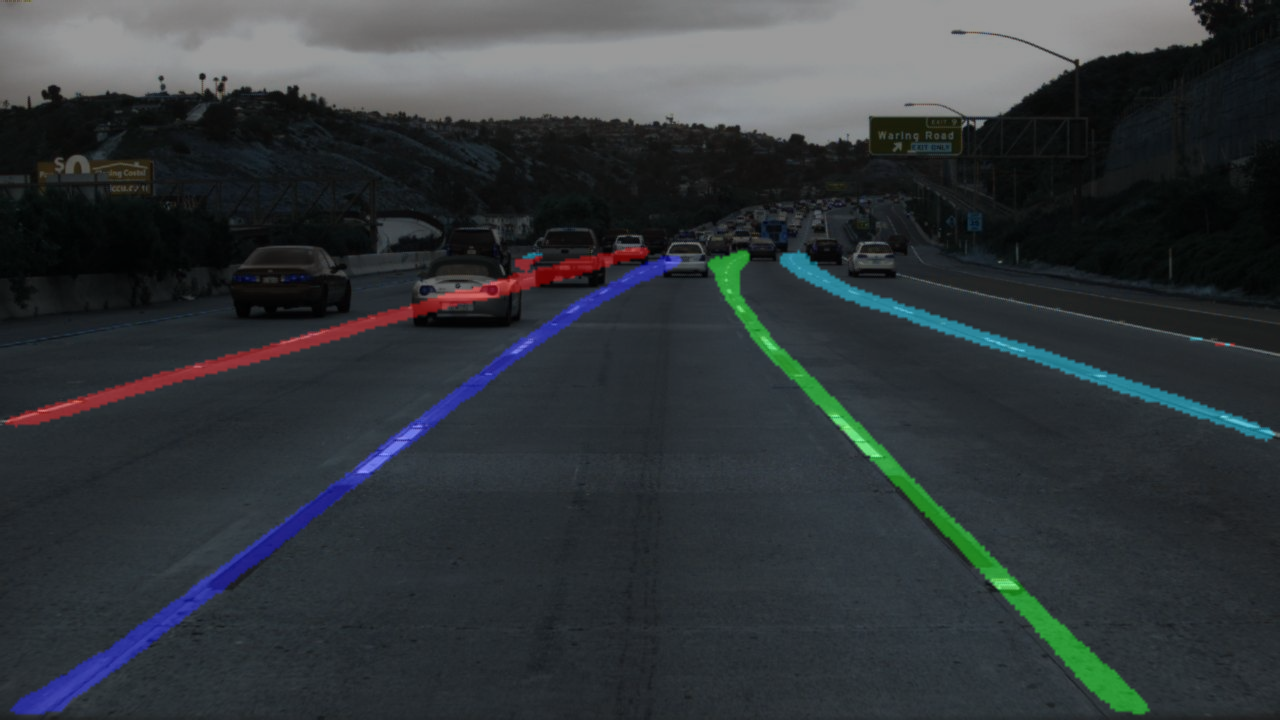

In [10]:
import os.path as ops
import numpy as np
import torch
import cv2
import time
import os
import matplotlib.pylab as plt
import sys
from tqdm import tqdm
import imageio
from dataset.dataset_utils import TUSIMPLE
from Lanenet.model2 import Lanenet
from utils.evaluation import gray_to_rgb_emb, process_instance_embedding
from google.colab.patches import cv2_imshow

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the Model
model_path = './TUSIMPLE/Lanenet_output/lanenet_epoch_39_batch_8.model'
LaneNet_model = Lanenet(2, 4)
LaneNet_model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
LaneNet_model.to(device)

def inference(gt_img_org):
    # BGR 순서
    org_shape = gt_img_org.shape
    gt_image = cv2.resize(gt_img_org, dsize=(512, 256), interpolation=cv2.INTER_LINEAR)
    gt_image = gt_image / 127.5 - 1.0
    gt_image = torch.tensor(gt_image, dtype=torch.float)
    gt_image = np.transpose(gt_image, (2, 0, 1))
    gt_image = gt_image.to(device)
    # lane segmentation 
    binary_final_logits, instance_embedding = LaneNet_model(gt_image.unsqueeze(0))
    binary_final_logits, instance_embedding = binary_final_logits.to('cpu'), instance_embedding.to('cpu') 
    binary_img = torch.argmax(binary_final_logits, dim=1).squeeze().numpy()
    binary_img[0:65,:] = 0

    # lane clustering & segemented frame embedding
    rbg_emb, cluster_result = process_instance_embedding(instance_embedding, binary_img,
                                                          distance=1.5, lane_num=4)

    rbg_emb = cv2.resize(rbg_emb, dsize=(org_shape[1], org_shape[0]), interpolation=cv2.INTER_LINEAR)
    a = 0.6
    frame = a * gt_img_org[..., ::-1] / 255 + rbg_emb * (1 - a)
    frame = np.rint(frame * 255)
    frame = frame.astype(np.uint8)

    return frame


image = cv2.imread('TUSIMPLE/test_clips/1494452927854312215/1.jpg')
cv2_imshow(inference(image))

In [11]:
def video2segemented_video(video_path):
    # TODO: video to frames
    cap = cv2.VideoCapture(video_path)
    frames = []
    while (cap.isOpened()):
      ret,image = cap.read()
      if (ret == False) : break
     

    # TODO: extract lane from frame
      img = inference(image)
      frames.append(img)
      
    height, width, layers = frames[0].shape
    size = (width, height)
    # TODO: frames to video & store video
    
    output = cv2.VideoWriter(video_path,cv2.VideoWriter_fourcc(*'DIVX'), 30, size)
    for i in range(len(frames)) :
      output.write(frames[i])
    cap.release()
    output.release()
    cv2.destroyAllWindows()


In [12]:
# Test
video_path = "/content/drive/MyDrive/test4.mp4" # input your video path
video2segemented_video(video_path)